Unscented Kalman Filter

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [16]:
# Unscented transform class for uncertainty propagation through a nonlinear model.
# For the algorithm, see State Estimation for Robotics, Timothy D. Barfoot, 2018, Chapter 4
class unscented_transform:
    def __init__(self, *args):
        if len(args) == 0:
            self.x_input = [] # input mean
            self.P = [] # input covariance
            self.func = [] # nonlinear model
            self.n = [] # input dimension
            self.kappa = [] # user-defined parameter to control the sigma points
        elif len(args) == 4:
            self.x_input = args[0]
            self.P = args[1]
            self.func = args[2]
            self.n = len(args[0])
            self.kappa = args[3]
        else:
            raise SystemExit('Input must be mean, cov, function, and kappa')
    
    def set(self, mean, cov, f, kappa):
        self.x_input = mean
        self.P = cov
        self.func = f
        self.n = len(mean)
        self.kappa = kappa
    
    def sigma_points(self):
        self.L = np.sqrt(self.n + self.kappa) * np.linalg.cholesky(self.P)
        Y = self.x_input.repeat(len(self.x_input), axis=1)
        self.X = np.hstack((self.x_input, Y + self.L, Y - self.L))
        self.w = np.zeros([2 * self.n + 1, 1]) #2n+1 sigma points weights
        self.w[0] = self.kappa / (self.n + self.kappa)
        self.w[1:] = 1 / (2*(self.n + self.kappa))
        self.w = self.w.reshape(-1)

    def propagate(self):
        # propagate the input gaussian using an unscented transform
        self.sigma_points()

        # compute sample mean and covariance
        self.mean = 0
        self.Cov = 0
        self.Y = []
        for i in range(2 * self.n + 1):
            Yvalue = self.func(self.X[:,i])
            self.Y.append(Yvalue)
            self.mean = self.mean + self.w[i] * Yvalue
        
        self.Y = (np.array(self.Y).reshape([2*self.n+1, -1])).T
        temp = self.Y - self.mean.reshape(2,1)
        self.Cov = temp @ np.diag(self.w) @ temp.T
        self.Cov_xy = (self.X - self.x_input) @ np.diag(self.w) @ (self.Y - self.mean.reshape(2,1)).T


In [17]:
# Test Unscented Transoform
# create a random mean and covariance
n = 3
x = np.random.randn(3, 1)
L = np.random.randn(3, 3)
P = np.dot(L, L.T)

A = np.random.randn(2, 3)

def f(z):
    return np.dot(A, z)

# propagate the uncertainty using UT and affine model to compare
kappa = 2
ut = unscented_transform(x, P, f, kappa)
ut.propagate()

print('kappa = ', kappa)
print('norm(ut.mean - A*x) = ', np.linalg.norm(ut.mean - np.dot(A, x).reshape(-1)))
temp = ut.Cov - np.dot((np.dot(A, P)), A.T)
print('norm(ut.Cov - A*P*A.T) = ', np.linalg.norm(temp))

kappa = 1
ut.set(x, P, f, kappa)
ut.propagate()

print('--------------------------------------------------------------')
print('kappa = ', kappa)
print('norm(ut.mean - A*x) = ', np.linalg.norm(ut.mean - np.dot(A, x).reshape(-1)))
temp = ut.Cov - np.dot((np.dot(A, P)), A.T)
print('norm(ut.Cov - A*P*A.T) = ', np.linalg.norm(temp, 'fro'))

kappa = 0
ut.set(x, P, f, kappa)
ut.propagate()

print('--------------------------------------------------------------')
print('kappa = ', kappa)
print('norm(ut.mean - A*x) = ', np.linalg.norm(ut.mean - np.dot(A, x).reshape(-1)))
temp = ut.Cov - np.dot((np.dot(A, P)), A.T)
print('norm(ut.Cov - A*P*A.T) = ', np.linalg.norm(temp, 'fro'))


kappa =  2
norm(ut.mean - A*x) =  4.965068306494546e-16
norm(ut.Cov - A*P*A.T) =  1.6011864169946884e-15
--------------------------------------------------------------
kappa =  1
norm(ut.mean - A*x) =  4.440892098500626e-16
norm(ut.Cov - A*P*A.T) =  1.0877919644084146e-15
--------------------------------------------------------------
kappa =  0
norm(ut.mean - A*x) =  0.0
norm(ut.Cov - A*P*A.T) =  4.440892098500626e-16


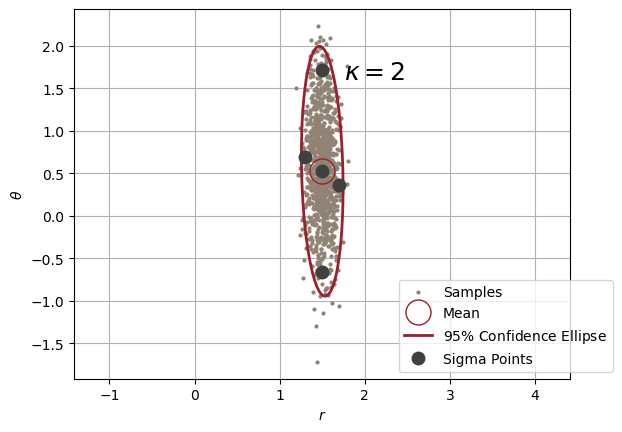

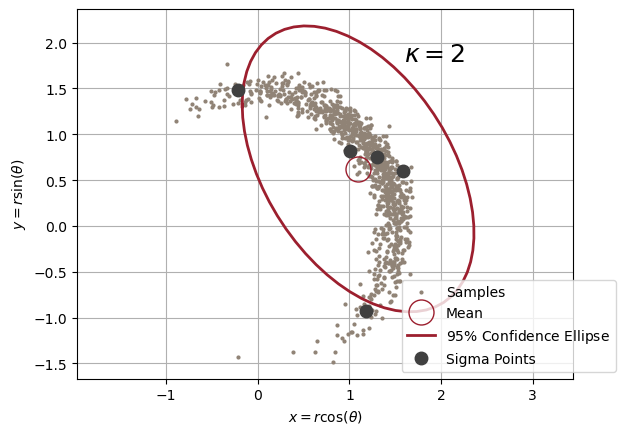

In [18]:
# Unscented Transform Example

# build a nonlinear map
def f(x):
    output = np.array([[x[0] * np.cos(x[1])], [x[0] * np.sin(x[1])]])
    return output.reshape([2, -1])


# An example of using the unscented transform for propagating a Gaussian distribution through a nonlinear map.
# We use polar to Cartesian for this code.

# create a random mean and covariance
x = np.array([[1.5], [np.pi / 6]])  # x = (r, theta)
# P = ap.array([[0.3 ** 2, -0.14 ** 2], [-0.14 ** 2, 0.35 ** 2]])
P = np.array([[0.1 ** 2, -0.09 ** 2], [-0.09 ** 2, 0.6 ** 2]])

# propagate the uncertainty using UT and affine model to compare
kappa = 2
ut = unscented_transform(x, P, f, kappa)
ut.propagate()

# visualization

# colors
green = np.array([0.298, 0.6, 0])
# crimson = np.array([220, 20, 60]) / 255
# darkblue = np.array([0, 0.2, 0.4])
Darkgrey = np.array([0.25, 0.25, 0.25])
# darkgrey = np.array([0.35, 0.35, 0.35])
# lightgrey = np.array([0.7, 0.7, 0.7])
# Lightgrey = np.array([0.9, 0.9, 0.9])
VermillionRed = np.array([156, 31, 46]) / 255
DupontGray = np.array([144, 131, 118]) / 255
# Azure = np.array([53, 112, 188]) / 255
# purple = np.array([178, 102, 255]) / 255
# orange = np.array([255, 110, 0]) / 255

# create confidence ellipse
# first create points from unit circle
phi = np.arange(-np.pi, np.pi+0.1, 0.1)
circle = np.array([np.cos(phi), np.sin(phi)])
# Chi-square 2-DOF 95% confidence (0.05):5.991
scale = np.sqrt(5.991)
# apply the transformation and scale of the covariance
ellipse_polar = (np.dot(scale * np.linalg.cholesky(P), circle) + x).T
ellipse_cartesian = (np.dot(scale * np.linalg.cholesky(ut.Cov), circle) + ut.mean).T

# generate samples for bmultivariate_normaloth polar and cartesian coordinates
s_polar = (np.dot(np.linalg.cholesky(P), np.random.randn(2, 1000)) + x).T
s_cartesian = np.zeros(np.shape(s_polar))
for i in range(s_polar.shape[0]):
    s_cartesian[i, :] = np.reshape(f(s_polar[i, :]), -1)

# plot in polar coordinates
fig1 = plt.figure()
plt.grid(True)
plt.axis('equal')
line1, = plt.plot(s_polar[:, 0], s_polar[:, 1], '.', color=DupontGray, markersize=4)
line2, = plt.plot(x[0], x[1], 'o', color=VermillionRed, markersize=18, fillstyle='none')
line3, = plt.plot(ellipse_polar[:, 0], ellipse_polar[:, 1], color=VermillionRed, linewidth=2)
line4, = plt.plot(ut.X[0, :], ut.X[1, :], '.', color=Darkgrey, markersize=18)
plt.xlabel(r'$r$')
plt.ylabel(r'$\theta$')
plt.legend([line1, line2, line3, line4], [r'Samples', r'Mean', r'$95\%$ Confidence Ellipse', r'Sigma Points'],
            loc='lower right', bbox_to_anchor=(1.1, 0))
plt.text(1.75, 1.6, r'$\kappa = 2$', fontsize=18)
plt.show()

# plot in Cartesian coordinates
fig2 = plt.figure()
plt.grid(True)
plt.axis('equal')
line1, = plt.plot(s_cartesian[:, 0], s_cartesian[:, 1], '.', color=DupontGray, markersize=4)
line2, = plt.plot(ut.mean[0], ut.mean[1], 'o', color=VermillionRed, markersize=18, fillstyle='none')
line3, = plt.plot(ellipse_cartesian[:, 0], ellipse_cartesian[:, 1], color=VermillionRed, linewidth=2)
line4, = plt.plot(ut.Y[0, :], ut.Y[1, :], '.', color=Darkgrey, markersize=18)
plt.xlabel(r'$x=r\cos(\theta)$')
plt.ylabel(r'$y=r\sin(\theta)$')
plt.legend([line1, line2, line3, line4], [r'Samples', r'Mean', r'$95\%$ Confidence Ellipse', r'Sigma Points'],
            loc='lower right', bbox_to_anchor=(1.1, 0))
plt.text(1.6, 1.8, r'$\kappa=2$', fontsize=18)
plt.show()


In [ ]:
def wrapToPi(x):
    """
    Wraps the input angle to the range [-pi, pi].
    """
    return (x + np.pi) % (2 * np.pi) - np.pi

class unscented_kalman_filter:
    def __init__(self, system, init):
        self.f = system.f  # process model
        self.Q = system.Q  # input noise covariance
        self.R = system.R  # measurement noise covariance
        self.h = system.h  # measurement model
        self.x = init.x  # state vector
        self.Sigma = init.Sigma  # state covariance
        self.ut = unscented_transform()  # UT instance for prediction and correction
        self.kappa_f = init.kappa_f  # user-defined parameter to control the sigma points
        self.kappa_h = init.kappa_h  # user-defined parameter to control the sigma points

    def prediction(self):
        # UKF propagation (prediction) step
        self.ut.set(self.x, self.Sigma, self.f, self.kappa_f)
        self.ut.propagate()

        self.x_pred = self.ut.mean
        self.Sigma_pred = self.ut.Cov + self.Q

        # Compute new sigma points to predict the measurement 
        self.ut.set(self.x_pred, self.Sigma_pred, self.h, self.kappa_h)
        self.ut.propagate()
        self.z_hat = self.ut.mean

    def correction(self, z):
        # compute innovation statistics
        # We know here z[1] is an angle
        self.v = z - self.z_hat  # innovation
        self.v[1] = wrapToPi(self.v[1])
        self.S = self.ut.Cov + self.R  # innovation covariance

        # compute state-measurement cross covariance
        self.Cov_xz = self.ut.Cov_xy  # state-measurement cross covariance

        # filter gain
        self.K = np.dot(self.Cov_xz, np.linalg.pinv(self.S))  # Kalman (filter) gain

        # correct the predicted state statistics
        self.x = self.x_pred + np.dot(self.K, self.v)
        self.Sigma = self.Sigma_pred - nps.dot(np.dot(self.K, self.S), self.K.T)

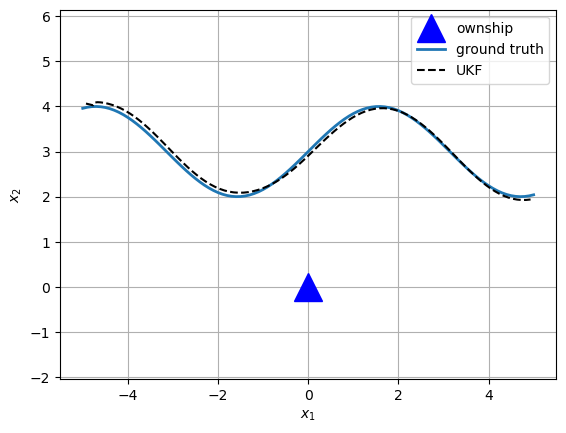

In [30]:
class myStruct():
    pass

# process model
def process_model(x):
    f = np.array([[x[0]],[x[1]]])
    return f.reshape([2, 1])

# measurement model
def measurement_model(x):
    h = np.array([[np.sqrt(np.sum(x[0]**2 + x[1]**2))],
                  [math.atan2(x[0], x[1])]])
    return h.reshape([2, 1])

def measurement_jacobian(x):
    H = np.array([[x[0]/np.sqrt(x[0]**2 + x[1]**2), x[1]/np.sqrt(x[0]**2 + x[1]**2)],
                  [x[1]/(x[0]**2 + x[1]**2), -x[0]/(x[0]**2 + x[1]**2)]])
    return H.reshape([2, 2])

# ground truth model
gt = myStruct()
gt.x = np.arange(-5, 5.1, 0.1)
gt.y = np.array(1 * np.sin(gt.x) + 3)

# measurements
R = np.diag(np.power([0.05, 0.01], 2))
# Cholesky factor of covariance for sampling
L = np.linalg.cholesky(R)
z = np.zeros([2, len(gt.x)])
for i in range(len(gt.x)):
    # sample from a zero mean Gaussian with covariance
    # noise = np.dot(L, np.random.randn(2, 1)).reshape(-1)
    noise = [0.01, 0.02]
    z[:, i] = np.array([np.sqrt(gt.x[i] ** 2 + gt.y[i] ** 2), math.atan2(gt.x[i], gt.y[i])]) + noise

# First we run EKF and then UKF for comparison
# build the system
sys = myStruct()
sys.A = np.eye(2)
sys.B = []
sys.f = process_model
sys.h = measurement_model
sys.H = measurement_jacobian
sys.Q = 1e-3 * np.eye(2)
sys.R = np.diag(np.power([0.05, 0.01], 2))

# initialize the state using the first measurement
init = myStruct()
init.x = np.zeros([2, 1])
init.x[0, 0] = z[0, 0] * np.sin(z[1, 0])
init.x[1, 0] = z[0, 0] * np.cos(z[1, 0])
init.Sigma = 1 * np.eye(2)

# Unscented Kalman Filter
init.kappa_f = 2
init.kappa_h = 2
ukf = unscented_kalman_filter(sys, init)
x_ukf = []
x_ukf.append(init.x)  # state
# main loop; iterate over the measurements
for i in range(1, np.shape(z)[1], 1):
    ukf.prediction()
    ukf.correction(z[:, i].reshape([2, 1]))
    x_ukf.append(ukf.x)
x_ukf = np.array(x_ukf).reshape([-1, 2])

# plotting
fig = plt.figure()
plt.grid(True)
plt.axis('equal')
line1, = plt.plot(0, 0, '^', color='blue', markersize=20)
line2, = plt.plot(gt.x, gt.y, '-', linewidth=2)
# line3, = plt.plot(x_ekf[:, 0], x_ekf[:, 1], '-.r', linewidth=2)
line4, = plt.plot(x_ukf[:, 0], x_ukf[:, 1], '--k', linewidth=1.5)
plt.legend([line1, line2, line4], [r'ownship', r'ground truth', r'UKF'], loc='best')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()
